# MLP
Like MLP_205 with K=5.

Epochs=200.

Prepare to exclude the middle.

In [47]:
from datetime import datetime
print(datetime.now())

2023-03-28 14:38:29.683279


In [48]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [49]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=200 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
FILTER_TAILS_TRAIN  = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TRAIN = False
FILTER_MIDDLE_TEST  = False
FILTER_NONE         = True

Python 3.9.16
sklearn 1.2.2


In [50]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [51]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [52]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [53]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(64, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    layer3 = Dense(64, activation='sigmoid')
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(layer3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return mlp

In [54]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-28 14:38:31.208928
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_132 (Dense)           (None, 64)                65664     
                                                                 
 dense_133 (Dense)           (None, 64)                4160      
                                                                 
 dense_134 (Dense)           (None, 64)                4160      
                                                                 
 dense_135 (Dense)           (None, 1)                 65        
                                                                 
Total params: 74,049
Trainable params: 74,049
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [55]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [56]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if FILTER_NONE or \
                    (FILTER_TAILS_TEST and in_middle) or \
                    (FILTER_MIDDLE_TEST and in_tails):
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if FILTER_NONE or \
                    (FILTER_TAILS_TRAIN and in_middle) or \
                    (FILTER_MIDDLE_TRAIN and in_tails):
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-03-28 14:38:31.351363
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4369 sequences.
2023-03-28 14:38:44.558052

Training # 1 1
2023-03-28 14:38:44.559027
2023-03-28 14:38:44.559084
Discriminator ZERO -1
Train 1:0 1800:1699 51.44%
Computed class weights: {0: 1.029723366686286, 1: 0.9719444444444445}
Valid 1:0 458:412 52.64%
FIT
2023-03-28 14:38:44.611152


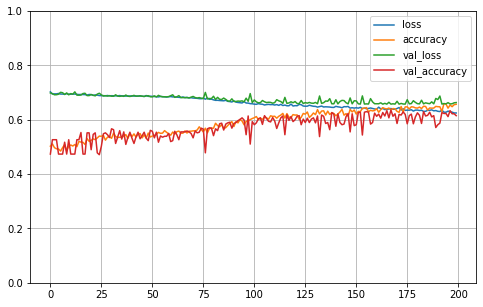


2023-03-28 14:39:45.393941

Testing # 1 1
2023-03-28 14:39:45.394350
2023-03-28 14:39:45.394379
PREDICT
2023-03-28 14:39:45.403223
Test 1:0 458:412 52.64%
Predict 1:0 641:229 73.68%
Test sizes (870, 1025) (870,)
Range of scores: 0.024899423 to 0.9656154
Score threshold 0.5
Confusion matrix
 [[153 259]
 [ 76 382]]
Normalized matrix
 [[0.17586207 0.29770115]
 [0.08735632 0.43908046]]


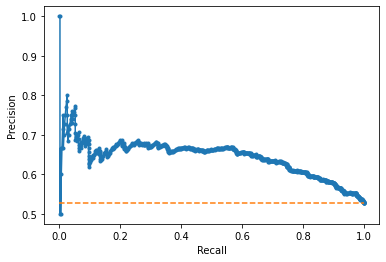

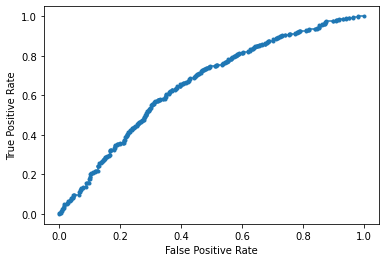

Accuracy: 61.49% Precision: 59.59% Recall: 83.41%
F1: 69.52% MCC: 0.2329
AUPRC: 64.43% AUROC: 65.80%
 accuracy [61.49425287356321]
 precision [59.59438377535101]
 recall [83.4061135371179]
 F1 [69.51774340309372]
 MCC [0.2329046043348652]
 AUPRC [64.42565203588316]
 AUROC [65.80107686437444]
2023-03-28 14:39:45.847182

Training # 1 2
2023-03-28 14:39:45.847372
2023-03-28 14:39:45.847444
Discriminator ZERO -1
Train 1:0 1816:1669 52.11%
Computed class weights: {0: 1.0440383463151588, 1: 0.9595264317180616}
Valid 1:0 442:442 50.00%
FIT
2023-03-28 14:39:45.920938


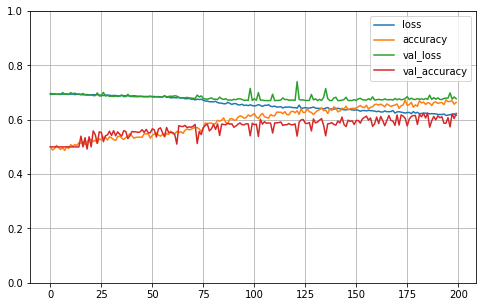


2023-03-28 14:40:48.365214

Testing # 1 2
2023-03-28 14:40:48.365344
2023-03-28 14:40:48.365387
PREDICT
2023-03-28 14:40:48.373215
Test 1:0 442:442 50.00%
Predict 1:0 559:325 63.24%
Test sizes (884, 1025) (884,)
Range of scores: 0.007604736 to 0.97445226
Score threshold 0.5
Confusion matrix
 [[217 225]
 [108 334]]
Normalized matrix
 [[0.24547511 0.25452489]
 [0.12217195 0.37782805]]


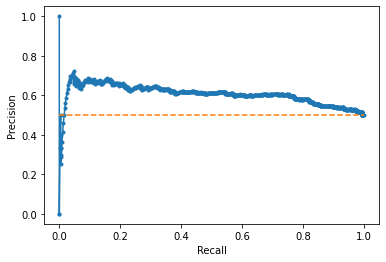

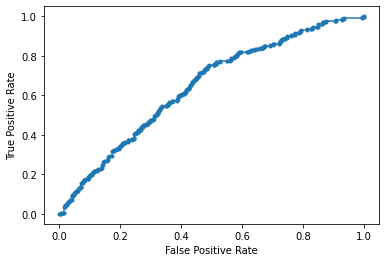

Accuracy: 62.33% Precision: 59.75% Recall: 75.57%
F1: 66.73% MCC: 0.2557
AUPRC: 60.50% AUROC: 64.44%
 accuracy [62.33031674208145]
 precision [59.74955277280859]
 recall [75.56561085972851]
 F1 [66.73326673326673]
 MCC [0.2557283717885217]
 AUPRC [60.50003049974245]
 AUROC [64.44175999672406]
2023-03-28 14:40:48.839688

Training # 1 3
2023-03-28 14:40:48.841231
2023-03-28 14:40:48.841299
Discriminator ZERO -1
Train 1:0 1816:1704 51.59%
Computed class weights: {0: 1.0328638497652582, 1: 0.9691629955947136}
Valid 1:0 442:407 52.06%
FIT
2023-03-28 14:40:48.899092


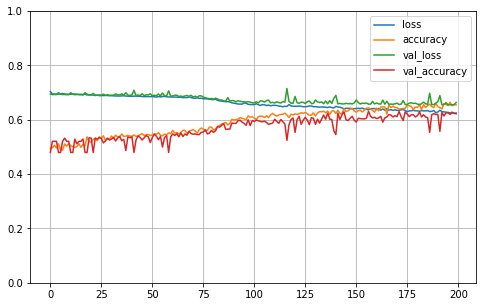


2023-03-28 14:41:49.085511

Testing # 1 3
2023-03-28 14:41:49.086929
2023-03-28 14:41:49.087293
PREDICT
2023-03-28 14:41:49.093059
Test 1:0 442:407 52.06%
Predict 1:0 317:532 37.34%
Test sizes (849, 1025) (849,)
Range of scores: 0.019072548 to 0.92988145
Score threshold 0.5
Confusion matrix
 [[309  98]
 [223 219]]
Normalized matrix
 [[0.3639576  0.11542992]
 [0.26266196 0.25795053]]


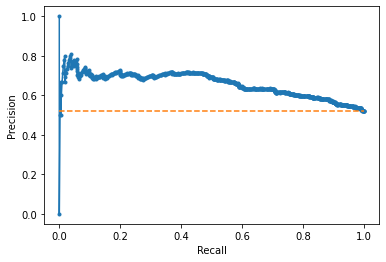

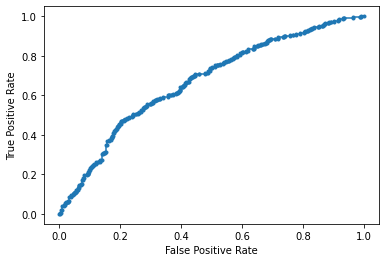

Accuracy: 62.19% Precision: 69.09% Recall: 49.55%
F1: 57.71% MCC: 0.2630
AUPRC: 65.76% AUROC: 66.96%
 accuracy [62.19081272084806]
 precision [69.08517350157729]
 recall [49.547511312217196]
 F1 [57.70750988142292]
 MCC [0.2630467028749929]
 AUPRC [65.75536174823547]
 AUROC [66.9610993140405]
2023-03-28 14:41:49.524178

Training # 1 4
2023-03-28 14:41:49.525363
2023-03-28 14:41:49.525561
Discriminator ZERO -1
Train 1:0 1799:1680 51.71%
Computed class weights: {0: 1.0354166666666667, 1: 0.9669260700389105}
Valid 1:0 459:431 51.57%
FIT
2023-03-28 14:41:49.585182


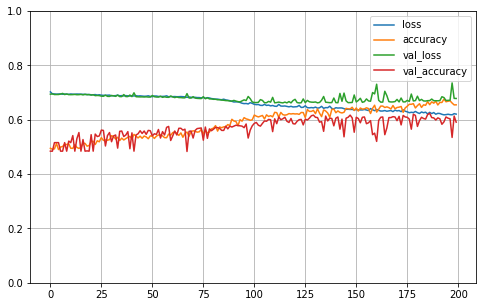


2023-03-28 14:43:12.981773

Testing # 1 4
2023-03-28 14:43:12.983117
2023-03-28 14:43:12.983437
PREDICT
2023-03-28 14:43:12.991345
Test 1:0 459:431 51.57%
Predict 1:0 645:245 72.47%
Test sizes (890, 1025) (890,)
Range of scores: 0.010770796 to 0.966874
Score threshold 0.5
Confusion matrix
 [[156 275]
 [ 89 370]]
Normalized matrix
 [[0.1752809  0.30898876]
 [0.1        0.41573034]]


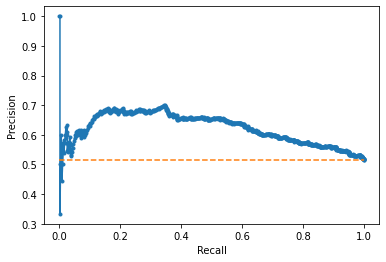

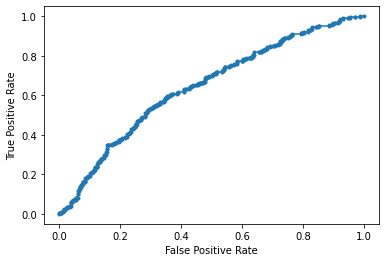

Accuracy: 59.10% Precision: 57.36% Recall: 80.61%
F1: 67.03% MCC: 0.1880
AUPRC: 62.26% AUROC: 64.43%
 accuracy [59.10112359550562]
 precision [57.36434108527132]
 recall [80.61002178649237]
 F1 [67.02898550724638]
 MCC [0.18802623934338825]
 AUPRC [62.260756667829085]
 AUROC [64.42988641705716]
2023-03-28 14:43:13.608742

Training # 1 5
2023-03-28 14:43:13.609243
2023-03-28 14:43:13.609298
Discriminator ZERO -1
Train 1:0 1801:1692 51.56%
Computed class weights: {0: 1.032210401891253, 1: 0.9697390338700722}
Valid 1:0 457:419 52.17%
FIT
2023-03-28 14:43:13.680750


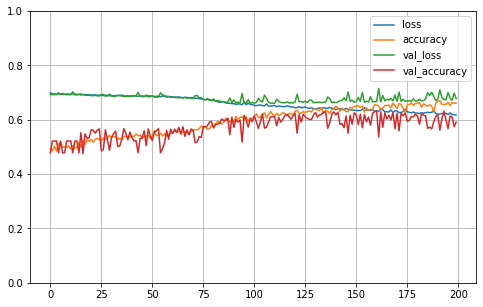


2023-03-28 14:44:16.850319

Testing # 1 5
2023-03-28 14:44:16.851491
2023-03-28 14:44:16.851753
PREDICT
2023-03-28 14:44:16.860063
Test 1:0 457:419 52.17%
Predict 1:0 643:233 73.40%
Test sizes (876, 1025) (876,)
Range of scores: 0.0076544243 to 0.97378194
Score threshold 0.5
Confusion matrix
 [[147 272]
 [ 86 371]]
Normalized matrix
 [[0.16780822 0.31050228]
 [0.09817352 0.42351598]]


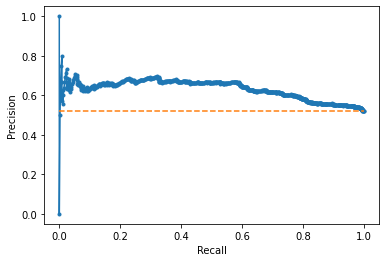

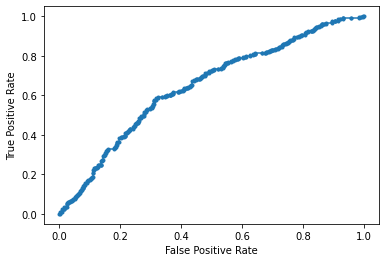

Accuracy: 59.13% Precision: 57.70% Recall: 81.18%
F1: 67.45% MCC: 0.1839
AUPRC: 63.16% AUROC: 64.66%
 accuracy [59.1324200913242]
 precision [57.698289269051315]
 recall [81.1816192560175]
 F1 [67.45454545454545]
 MCC [0.1838822362559718]
 AUPRC [63.159606898189224]
 AUROC [64.66370382749382]
2023-03-28 14:44:17.505554

Training # 2 1
2023-03-28 14:44:17.506993
2023-03-28 14:44:17.507269
Discriminator ZERO -1
Train 1:0 1786:1696 51.29%
Computed class weights: {0: 1.0265330188679245, 1: 0.9748040313549832}
Valid 1:0 472:415 53.21%
FIT
2023-03-28 14:44:17.579235


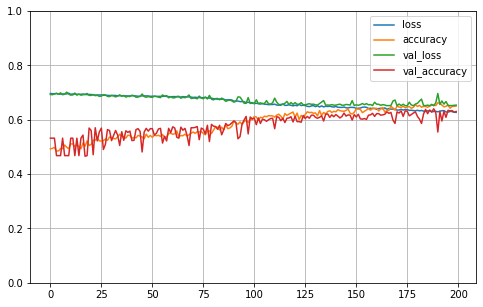


2023-03-28 14:45:19.502464

Testing # 2 1
2023-03-28 14:45:19.503633
2023-03-28 14:45:19.503918
PREDICT
2023-03-28 14:45:19.514273
Test 1:0 472:415 53.21%
Predict 1:0 470:417 52.99%
Test sizes (887, 1025) (887,)
Range of scores: 0.03674868 to 0.98735774
Score threshold 0.5
Confusion matrix
 [[252 163]
 [165 307]]
Normalized matrix
 [[0.28410372 0.1837655 ]
 [0.18602029 0.34611048]]


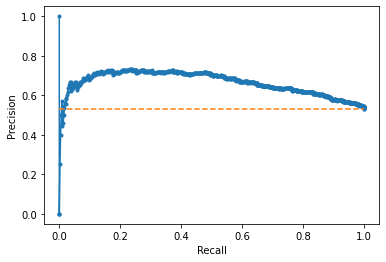

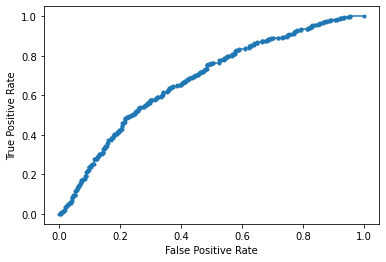

Accuracy: 63.02% Precision: 65.32% Recall: 65.04%
F1: 65.18% MCC: 0.2576
AUPRC: 66.27% AUROC: 67.90%
 accuracy [63.021420518602035]
 precision [65.31914893617021]
 recall [65.04237288135593]
 F1 [65.18046709129511]
 MCC [0.2575803301521668]
 AUPRC [66.27390723442834]
 AUROC [67.90024504798858]
2023-03-28 14:45:20.166497

Training # 2 2
2023-03-28 14:45:20.168006
2023-03-28 14:45:20.168308
Discriminator ZERO -1
Train 1:0 1806:1695 51.59%
Computed class weights: {0: 1.0327433628318583, 1: 0.9692691029900332}
Valid 1:0 452:416 52.07%
FIT
2023-03-28 14:45:20.250084


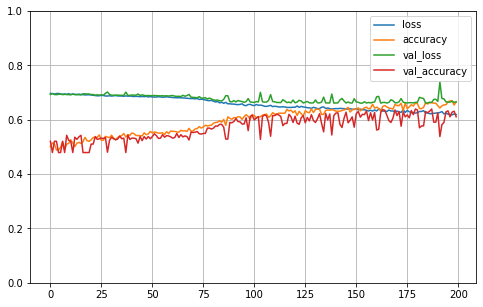


2023-03-28 14:46:43.359309

Testing # 2 2
2023-03-28 14:46:43.359703
2023-03-28 14:46:43.359740
PREDICT
2023-03-28 14:46:43.367343
Test 1:0 452:416 52.07%
Predict 1:0 620:248 71.43%
Test sizes (868, 1025) (868,)
Range of scores: 0.016125448 to 0.9700353
Score threshold 0.5
Confusion matrix
 [[163 253]
 [ 85 367]]
Normalized matrix
 [[0.18778802 0.29147465]
 [0.09792627 0.42281106]]


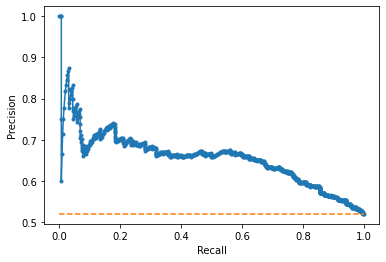

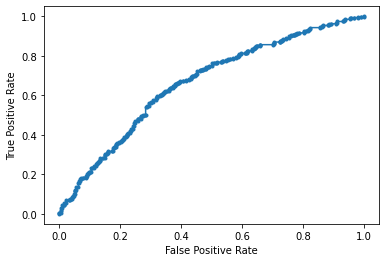

Accuracy: 61.06% Precision: 59.19% Recall: 81.19%
F1: 68.47% MCC: 0.2253
AUPRC: 65.62% AUROC: 66.31%
 accuracy [61.05990783410138]
 precision [59.193548387096776]
 recall [81.19469026548673]
 F1 [68.47014925373134]
 MCC [0.22534223461774475]
 AUPRC [65.615333959621]
 AUROC [66.31291482300885]
2023-03-28 14:46:43.822693

Training # 2 3
2023-03-28 14:46:43.823619
2023-03-28 14:46:43.823807
Discriminator ZERO -1
Train 1:0 1805:1704 51.44%
Computed class weights: {0: 1.0296361502347418, 1: 0.97202216066482}
Valid 1:0 453:407 52.67%
FIT
2023-03-28 14:46:43.882910


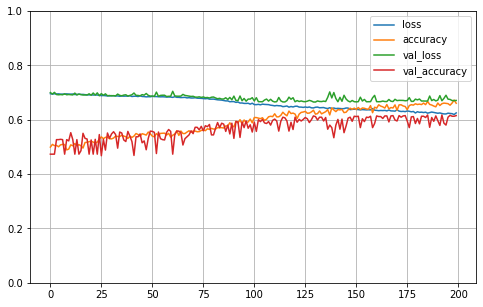


2023-03-28 14:47:46.290389

Testing # 2 3
2023-03-28 14:47:46.290786
2023-03-28 14:47:46.290819
PREDICT
2023-03-28 14:47:46.300173
Test 1:0 453:407 52.67%
Predict 1:0 570:290 66.28%
Test sizes (860, 1025) (860,)
Range of scores: 0.008775728 to 0.9574725
Score threshold 0.5
Confusion matrix
 [[183 224]
 [107 346]]
Normalized matrix
 [[0.2127907  0.26046512]
 [0.1244186  0.40232558]]


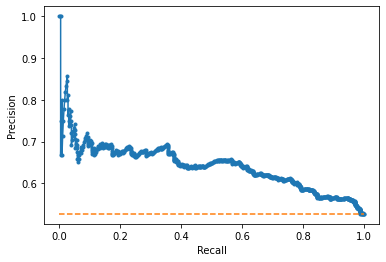

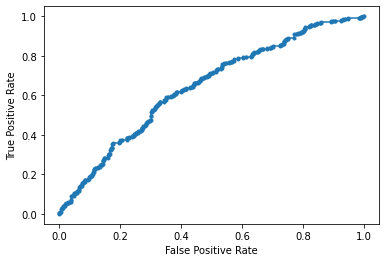

Accuracy: 61.51% Precision: 60.70% Recall: 76.38%
F1: 67.64% MCC: 0.2254
AUPRC: 64.20% AUROC: 64.36%
 accuracy [61.51162790697674]
 precision [60.70175438596491]
 recall [76.37969094922738]
 F1 [67.64418377321604]
 MCC [0.22540420010996742]
 AUPRC [64.1958082321245]
 AUROC [64.35719283401401]
2023-03-28 14:47:46.781157

Training # 2 4
2023-03-28 14:47:46.782097
2023-03-28 14:47:46.782923
Discriminator ZERO -1
Train 1:0 1826:1664 52.32%
Computed class weights: {0: 1.0486778846153846, 1: 0.9556407447973713}
Valid 1:0 432:447 49.15%
FIT
2023-03-28 14:47:46.838118


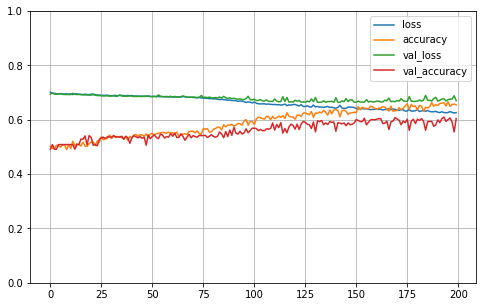


2023-03-28 14:48:49.640915

Testing # 2 4
2023-03-28 14:48:49.641338
2023-03-28 14:48:49.641375
PREDICT
2023-03-28 14:48:49.650004
Test 1:0 432:447 49.15%
Predict 1:0 426:453 48.46%
Test sizes (879, 1025) (879,)
Range of scores: 0.011571068 to 0.92019933
Score threshold 0.5
Confusion matrix
 [[276 171]
 [177 255]]
Normalized matrix
 [[0.31399317 0.19453925]
 [0.20136519 0.29010239]]


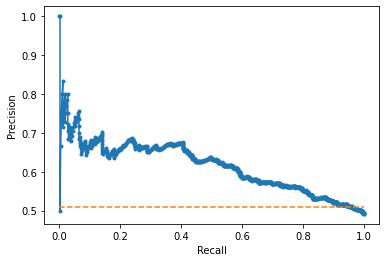

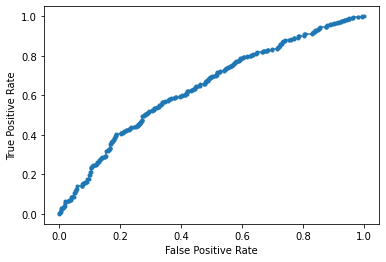

Accuracy: 60.41% Precision: 59.86% Recall: 59.03%
F1: 59.44% MCC: 0.2078
AUPRC: 61.51% AUROC: 64.16%
 accuracy [60.40955631399317]
 precision [59.859154929577464]
 recall [59.02777777777778]
 F1 [59.44055944055944]
 MCC [0.2077952462750227]
 AUPRC [61.50938295970623]
 AUROC [64.15920954511559]
2023-03-28 14:48:50.153633

Training # 2 5
2023-03-28 14:48:50.155747
2023-03-28 14:48:50.156102
Discriminator ZERO -1
Train 1:0 1809:1685 51.77%
Computed class weights: {0: 1.0367952522255193, 1: 0.9657269209508016}
Valid 1:0 449:426 51.31%
FIT
2023-03-28 14:48:50.232980


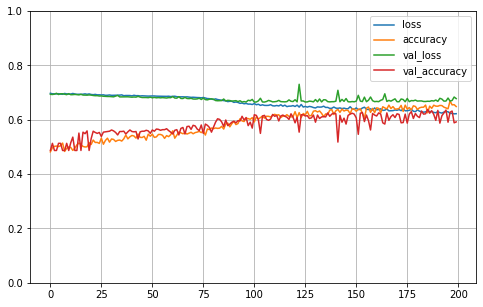


2023-03-28 14:50:13.304475

Testing # 2 5
2023-03-28 14:50:13.304534
2023-03-28 14:50:13.304560
PREDICT
2023-03-28 14:50:13.314035
Test 1:0 449:426 51.31%
Predict 1:0 318:557 36.34%
Test sizes (875, 1025) (875,)
Range of scores: 0.016821427 to 0.9705107
Score threshold 0.5
Confusion matrix
 [[313 113]
 [244 205]]
Normalized matrix
 [[0.35771429 0.12914286]
 [0.27885714 0.23428571]]


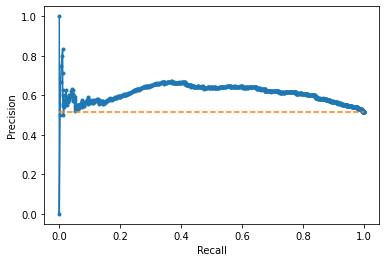

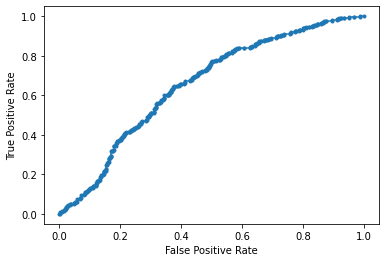

Accuracy: 59.20% Precision: 64.47% Recall: 45.66%
F1: 53.46% MCC: 0.1988
AUPRC: 61.11% AUROC: 65.65%
 accuracy [59.199999999999996]
 precision [64.46540880503144]
 recall [45.657015590200444]
 F1 [53.45501955671447]
 MCC [0.1988057256550619]
 AUPRC [61.106479186863716]
 AUROC [65.6482323786819]
2023-03-28 14:50:14.359863


In [57]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [58]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 60.95% std 1.43
 precision mean 61.30% std 3.76
 recall mean 69.76% std 14.02
 F1 mean 64.26% std 5.42
 MCC mean 0.22% std 0.03
 AUPRC mean 63.48% std 2.08
 AUROC mean 65.47% std 1.28
 accuracy [[61.49425287356321], [62.33031674208145], [62.19081272084806], [59.10112359550562], [59.1324200913242], [63.021420518602035], [61.05990783410138], [61.51162790697674], [60.40955631399317], [59.199999999999996]]
 precision [[59.59438377535101], [59.74955277280859], [69.08517350157729], [57.36434108527132], [57.698289269051315], [65.31914893617021], [59.193548387096776], [60.70175438596491], [59.859154929577464], [64.46540880503144]]
 recall [[83.4061135371179], [75.56561085972851], [49.547511312217196], [80.61002178649237], [81.1816192560175], [65.04237288135593], [81.19469026548673], [76.37969094922738], [59.02777777777778], [45.657015590200444]]
 F1 [[69.51774340309372], [66.73326673326673], [57.70750988142292], [67.02898550724638], [67.45454545454545], [65.18046709129511], [68.